# Chromo - A Software for Radiochromic Film Processing

In [1]:
#PARAMETRI MODIFICABILI

path='scansPoli/' #PATH DELLE CARTELLE CALIBRATION TREATMENT E OUTPUT

maxdoseRecalibration = 6 #DOSE MASSIMA DI RICALIBRAZIONE (Gy)
dpi = 150
dimensioneRoiPixel = 4 #es. 4=> 4x4
isodoseDifferenceGy = 0.1 #DIFFERENZA ISODOSI DI VISUALIZZAZIONE (Gy)

redChannel=2 #ORDINE RGB
greenChannel=1 #ORDINE RGB
blueChannel=0 #ORDINE RGB

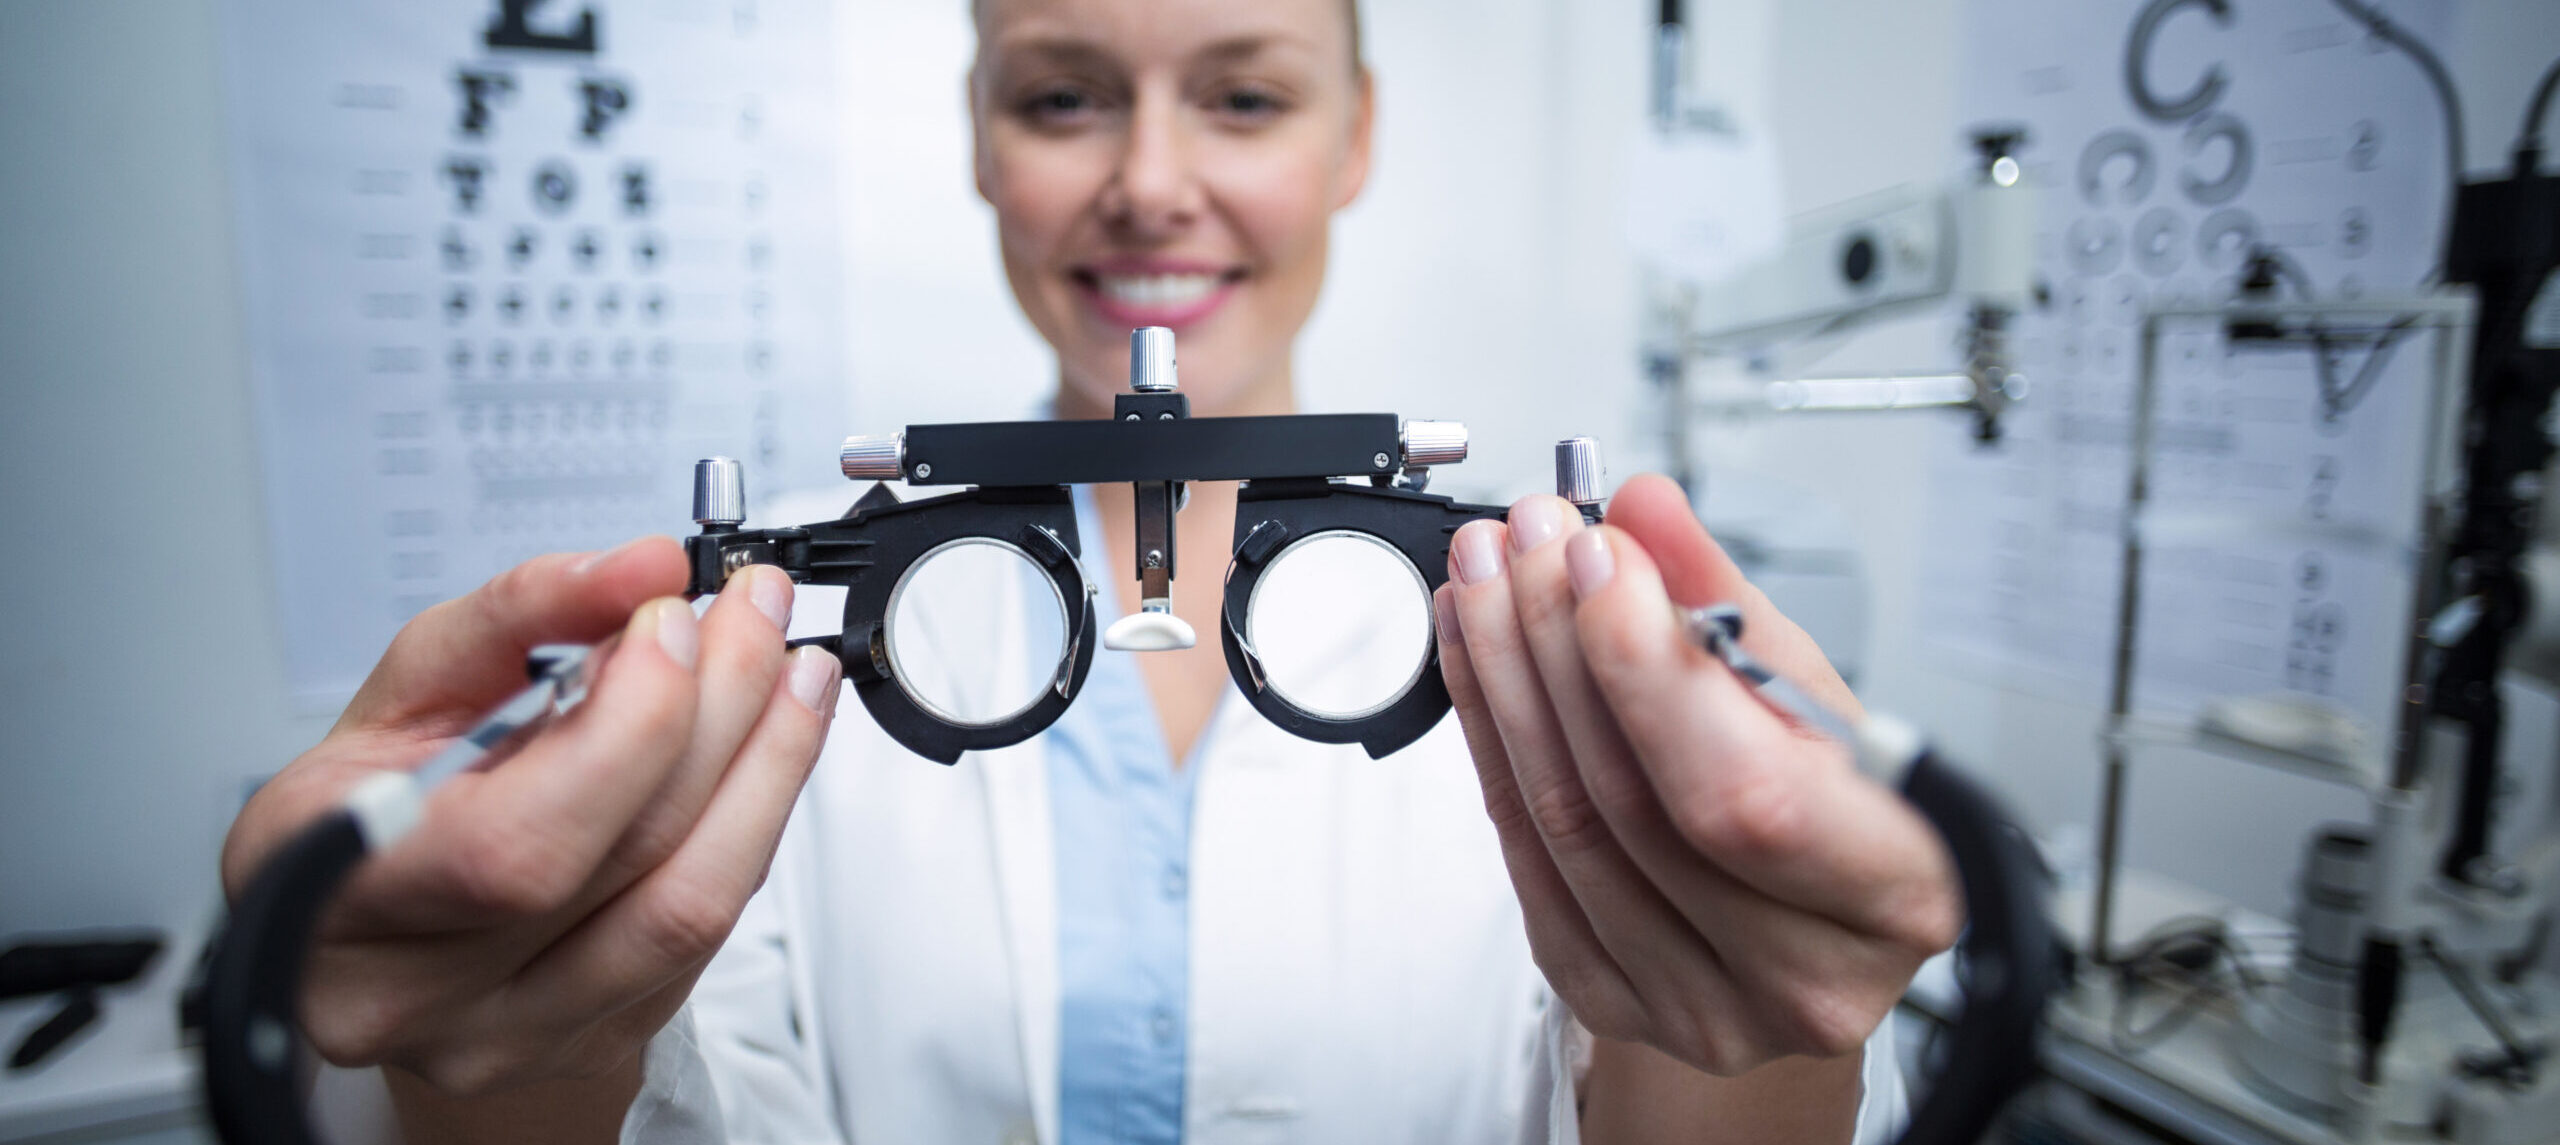

In [2]:
#TODO:
#fit razionale OK
#LS 3 colori OK
#ricalibrazione con d0 e dmax ok
#filtro mediano OK
#filtro wiener OK
#funzione inversa per dose-risposte risposta-dose OK 
#inverso della ricalibrazione dose-risposte risposta-dose OK
#media delle immagini di calibrazione solo al centro OK
#plottare i profili OK
#normalizzazione

import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import numpy as np
from glob import glob
import re
import numpy as np
import math
from scipy import ndimage
from matplotlib import gridspec
import matplotlib.pyplot as plt
from PIL import Image
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline
from scipy.signal import medfilt, wiener
from pynverse import inversefunc
import cv2
import PIL
import time
from IPython.display import Image
import os
import glob as gb
from scipy.interpolate import Rbf
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
Image(filename='mpj2.jpg') #cambiare modificando il nome

In [3]:
dpiResolution = 25.4 / dpi

def a_recalibration(yp1, yp2, y1, y2):
    return (y2*yp1-y1*yp2)/(y2-y1)

def b_recalibration(yp1, yp2, y1, y2):
    return (yp2-yp1)/(y2-y1)

def rational(x, a, b, c):
    return a + b/(x+c)

def rational_inverse(x, a, b, c):
    return (b +a*c - x*c)/(x-a)

def multichannel_model(a, x):
    return a[0] + a[1]/(x+a[2])

def multichannel_function(a, x, y):
    return multichannel_model(a, x) - y

def jac(a, x, y):
    J = np.empty((x.size, a.size))
    J[:, 0] = 1
    J[:, 1] = 1/(x + a[2])
    J[:, 2] = (-a[1])/(x+a[2])**2
    return J

def multichannel_function_inverse(a, x, y):
    return multichannel_model_inverse(a, x) - y 
    
def multichannel_model_inverse(a, x):
    return (a[1] + a[0]*a[2] - a[2]*x)/(x - a[0])

def jac_inverse(a, x, y):
    J = np.empty((x.size, a.size))
    J[:, 0] = (-a[1])/(x-a[0])**2
    J[:, 1] = 1/(x - a[0])
    J[:, 2] = -1
    return J

def averageImages(images):
    sumIm = 0
    for im in images:
        sumIm += im
    return im/len(images)

def create_inverse_spline(spline):    
    def inverse_spline(x_array):
        if type(x_array) is np.float64:
            x_array
            return return_inverse(x_array, spline)
        else:
            shape = np.shape(x_array)
            dim = len(shape)
            y = np.zeros(shape)
            
            if dim == 1:
                for i, x in enumerate(x_array):
                    y[i] = return_inverse(x, spline)
                    
            else:                
                for i in range(shape[0]):
                    for j in range(shape[1]):
                        x = x_array[i, j]
                        y[i, j] = return_inverse(x, spline)
            return y 
    return inverse_spline

def return_inverse(x, spline):
    def to_minimise(y):
        return (spline(y) - x)**2
    result = minimize(to_minimise, [6])
    return result.x

def projection(image):
    proiezionex = []
    proiezioney = []
    sizex, sizey = image.shape
    for i in range(0,sizey):
        cumsumy = 0
        for j in range(0, sizex):
            cumsumy += image[i][j]
        proiezioney.append(cumsumy)
    proiezioney_arr = np.asanyarray(proiezioney)
    
    for i in range(0,sizex):
        cumsumx = 0
        for j in range(0, sizey):
            cumsumx += image[j][i]
        proiezionex.append(cumsumx)
    proiezionex_arr = np.asanyarray(proiezionex)
    return(proiezionex_arr, proiezioney_arr)

def projectionSingle(image):
    sizex, sizey = image.shape
    yprofile = image[: , int(sizey/2)]
    xprofile = image[int(sizex/2) , :]
    return(xprofile, yprofile)

def calibration_factors_calculator(zeroResponse, maxdoseResponse):
        a = a_recalibration(zeroResponse, #x1
                            maxdoseResponse, #x2
                            multichannel_model(fitResults.x, 0), #n1
                            multichannel_model(fitResults.x, maxdoseRecalibration)) #n2
        b = b_recalibration(zeroResponse,
                            maxdoseResponse,
                            multichannel_model(fitResults.x, 0), #n1
                            multichannel_model(fitResults.x, maxdoseRecalibration)) #n2 
        return (a, b)

        
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text 
    
def plotTiff(listTiffs, prefix):
    rows = 3
    for num, x in enumerate(listTiffs):
        img = PIL.Image.open(x)
        plt.subplot(rows,2,num+1)
        plt.title(remove_prefix(x, prefix).split('.')[0])
        plt.axis('off')
        plt.imshow(img)
        
def startString():
    print("STARTING DOSE CALCULATION.")
    time.sleep(1)
    print("STARTING DOSE CALCULATION..")
    time.sleep(1)
    print("STARTING DOSE CALCULATION...")
    time.sleep(1)
    print("STARTING DOSE CALCULATION....")
    time.sleep(1)
    print("thank you for using Chromo :)")
    time.sleep(2.5)
    print()

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

def plot_gaussian(x,y, string, colorstring):
    n = len(x)                         
    mean = sum(x*y)/n                   
    sigma = sum(y*(x-mean)**2)/n     

    popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

    plt.plot(x,y,'b+:',label='data')
    plt.plot(x,gaus(x,*popt),colorstring,label='fit')
    plt.legend()
    plt.title('Gaussian interpolation of ' + string)
    plt.xlabel('y')
    plt.ylabel('x')
    plt.show()
    fwhm_pixel = 2.355*popt[2]
    fwhm_mm = abs(fwhm_pixel*dpiResolution)
    print('Gaussian FWHM of ' + string + ': ' + str(round(fwhm_mm,2)) +' mm')
    
    return 0  

def find_nearest(array, value):
    length = len(array)
    middle_index = int(length // 2)
    array1 = array[:middle_index]
    array2 = array[middle_index:]
    
    array1 = np.asarray(array1)
    array2 = np.asarray(array2)
    idx1 = (np.abs(array1 - value)).argmin()
    idx2 = (np.abs(array2 - value)).argmin() + middle_index
    return (idx1, idx2)

def find_fwhm_analytical(dose, halfvaluex, halfvaluey, stringColor):
    projx, projy = projectionSingle(dose) 
    idx1, idx2 = find_nearest(projx, halfvaluex)
    idy1, idy2 = find_nearest(projy, halfvaluey)
    fwhmx = (idx2 - idx1)*dpiResolution
    fwhmy = (idy2 - idy1)*dpiResolution
    print('Analytical FWHM of ' + stringColor + ' x dose: ' + str(round(fwhmx,2)) +' mm')
    print('Analytical FWHM of ' + stringColor + ' y dose: ' + str(round(fwhmy,2)) +' mm')
    return 0

calibration film list:
['scansPoli/CALIBRATION/calibration_10Gy_1.tif'
 'scansPoli/CALIBRATION/calibration_15Gy_1.tif'
 'scansPoli/CALIBRATION/calibration_2Gy_1.tif'
 'scansPoli/CALIBRATION/calibration_5Gy_1.tif'
 'scansPoli/CALIBRATION/calibration_7Gy_1.tif']


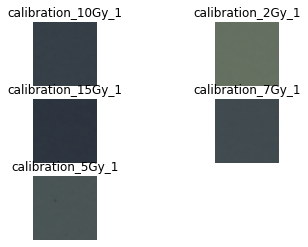

unexposed calibration film list:
['scansPoli/CALIBRATION/unexposed_calibration_0Gy_1.tif']


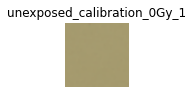

treatment film:
['scansPoli/TREATMENT/treatment_16XY.tif'
 'scansPoli/TREATMENT/treatment_16XZ.tif'
 'scansPoli/TREATMENT/treatment_4XY.tif'
 'scansPoli/TREATMENT/treatment_4XZ.tif'
 'scansPoli/TREATMENT/treatment_8XY.tif'
 'scansPoli/TREATMENT/treatment_8XZ.tif']


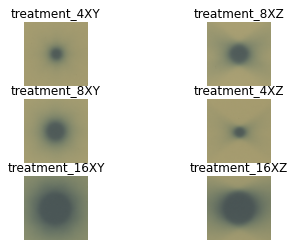

unexposed recalibration film:
['scansPoli/TREATMENT/unexposed_treatment_0Gy_16XY.tif'
 'scansPoli/TREATMENT/unexposed_treatment_0Gy_16XZ.tif'
 'scansPoli/TREATMENT/unexposed_treatment_0Gy_4XY.tif'
 'scansPoli/TREATMENT/unexposed_treatment_0Gy_4XZ.tif'
 'scansPoli/TREATMENT/unexposed_treatment_0Gy_8XY.tif'
 'scansPoli/TREATMENT/unexposed_treatment_0Gy_8XZ.tif']


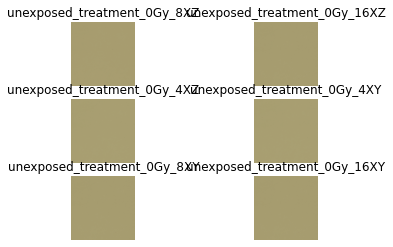

maxdose recalibration film:
['scansPoli/TREATMENT/maxdose_treatment_16XY.tif'
 'scansPoli/TREATMENT/maxdose_treatment_16XZ.tif'
 'scansPoli/TREATMENT/maxdose_treatment_4XY.tif'
 'scansPoli/TREATMENT/maxdose_treatment_4XZ.tif'
 'scansPoli/TREATMENT/maxdose_treatment_8XY.tif'
 'scansPoli/TREATMENT/maxdose_treatment_8XZ.tif']


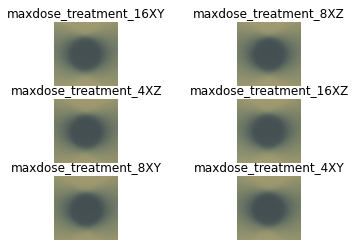

In [4]:
print("calibration film list:")
calibration_list = glob(path+"CALIBRATION/calibration*")  
print(np.sort(calibration_list))
plotTiff(calibration_list, path+ "CALIBRATION/")
plt.show()

unexposed_calibration_list = glob(path+"CALIBRATION/unexposed_calibration*")
print("unexposed calibration film list:")
print(np.sort(unexposed_calibration_list))
plotTiff(unexposed_calibration_list, path+ "CALIBRATION/")
plt.show()

treatment_list = glob(path+"TREATMENT/treatment*")
print("treatment film:")
print(np.sort(treatment_list))
plotTiff(treatment_list, path + "TREATMENT/")
plt.show()

unexposed_treatment_list = glob(path+"TREATMENT/unexposed_treatment*")
print("unexposed recalibration film:")
print(np.sort(unexposed_treatment_list))
plotTiff(unexposed_treatment_list, path + "TREATMENT/")
plt.show()

maxdose_treatment_list = glob(path+"TREATMENT/maxdose_treatment*")
print("maxdose recalibration film:")
print(np.sort(maxdose_treatment_list))
plotTiff(maxdose_treatment_list, path + "TREATMENT/")
plt.show()

In [5]:
calibration_dose = []
calibration_red = []
calibration_green = []
calibration_blue = []
unexposedImages = []
unexposedImagesRed = []
unexposedImagesGreen = []
unexposedImagesBlue = []
unexposedTreatementImages = []
unexposedTreatementsImagesRed = []
unexposedTreatementsImagesGreen = []
unexposedTreatementsImagesBlue = []
maxdoseTreatementImages = []
maxdoseTreatementsImagesRed = []
maxdoseTreatementsImagesGreen = []
maxdoseTreatementsImagesBlue = []
rescaled_unexposed_red = []
rescaled_maxdose_red = []

import tifffile as tiff
    
for i, scan_filepath in enumerate(unexposed_calibration_list):
    reg0_search = re.search('.*unexposed_calibration*', scan_filepath)
    calibration_dose.append(0)

    image = cv2.imread(scan_filepath)
    xshapeimage = int(image.shape[0]/2)
    yshapeimage = int(image.shape[0]/2)
    unexposedImages.append(image)
    unexposedImagesRed.append(image[:,:,redChannel])
    unexposedImagesGreen.append(image[:,:,greenChannel])
    unexposedImagesBlue.append(image[:,:,blueChannel])
        
    calibration_red.append(np.mean(image[xshapeimage-5:xshapeimage+5,yshapeimage-5:yshapeimage+5,redChannel]))
    calibration_green.append(np.mean(image[xshapeimage-5:xshapeimage+5,yshapeimage-5:yshapeimage+5,greenChannel]))
    calibration_blue.append(np.mean(image[xshapeimage-5:xshapeimage+5,yshapeimage-5:yshapeimage+5,blueChannel]))
    #prendo la media di ogni canale per la calibrazione di ogni immagine

unexposedCal = averageImages(unexposedImages)

for i, scan_filepath in enumerate(calibration_list):
    reg_search = re.search('.*calibration_(.*)Gy_.*', scan_filepath)
    calibration_dose.append(reg_search.group(1))
    
    image = cv2.imread(scan_filepath)
    netImage = image #/unexposedCal
    calibration_red.append(np.mean(netImage[xshapeimage-5:xshapeimage+5,yshapeimage-5:yshapeimage+5,redChannel]))
    calibration_green.append(np.mean(netImage[xshapeimage-5:xshapeimage+5,yshapeimage-5:yshapeimage+5,greenChannel]))
    calibration_blue.append(np.mean(netImage[xshapeimage-5:xshapeimage+5,yshapeimage-5:yshapeimage+5,blueChannel]))
    #prendo la media di ogni canale per la calibrazione di ogni immagine
    
for i, scan_filepath in enumerate(unexposed_treatment_list):
    reg_search = re.search('.*unexposed_treatment*', scan_filepath)
    
    image = cv2.imread(scan_filepath)
    unexposedTreatementImages.append(image)
    unexposedTreatementsImagesRed.append(image[:,:,redChannel])
    unexposedTreatementsImagesGreen.append(image[:,:,greenChannel])
    unexposedTreatementsImagesBlue.append(image[:,:,blueChannel])

for i, scan_filepath in enumerate(maxdose_treatment_list):
    reg_search = re.search('.*maxdose_treatment*', scan_filepath)
    
    image = cv2.imread(scan_filepath)
    maxdoseTreatementImages.append(image)
    maxdoseTreatementsImagesRed.append(image[:,:,redChannel])
    maxdoseTreatementsImagesGreen.append(image[:,:,greenChannel])
    maxdoseTreatementsImagesBlue.append(image[:,:,blueChannel])

In [6]:
calibration_dose = np.array(calibration_dose).astype(float)
calibration_red = np.array(calibration_red).astype(float)
calibration_green = np.array(calibration_green).astype(float)
calibration_blue = np.array(calibration_blue).astype(float)

initial_sorting_reference = np.argsort(calibration_dose)
calibration_dose = calibration_dose[initial_sorting_reference]
calibration_red = calibration_red[initial_sorting_reference]
calibration_green = calibration_green[initial_sorting_reference]
calibration_blue = calibration_blue[initial_sorting_reference]

RED POINTS CURVE



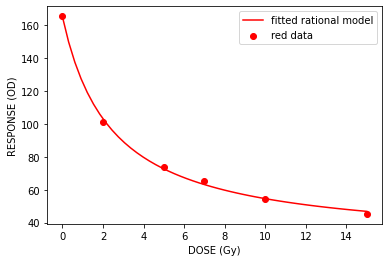

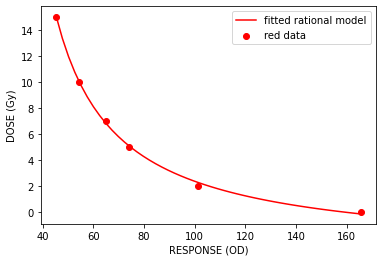

In [7]:
d = np.linspace(np.min(calibration_dose), np.max(calibration_dose))
p0 = -10., 200., 3. #da cambiare eventualmente il punto iniziale

print("RED POINTS CURVE")
print()

poptRed = curve_fit(rational, calibration_dose, calibration_red, p0, maxfev=1000)[0]
plt.scatter(calibration_dose, calibration_red, color='red', label='red data')
plt.plot(d, rational(d, *poptRed), 'r-', label='fitted rational model')
plt.xlabel("DOSE (Gy)")
plt.ylabel("RESPONSE (OD)")
plt.legend(loc='upper right')
plt.show()

r = np.linspace(np.min(calibration_red), np.max(calibration_red))
p0 = -10., 300., 3. #da cambiare eventualmente il punto iniziale

poptRedInverse = curve_fit(rational_inverse, calibration_red, calibration_dose, p0, maxfev=1000)[0]
plt.scatter(calibration_red, calibration_dose, color='red', label='red data')
plt.plot(r, rational_inverse(r, *poptRedInverse), 'r-', label='fitted rational model')
plt.xlabel("RESPONSE (OD)")
plt.ylabel("DOSE (Gy)")
plt.legend(loc='upper right')
plt.show()

GREEN POINTS CURVE



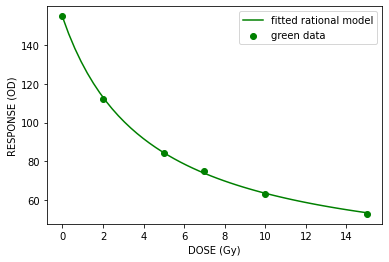

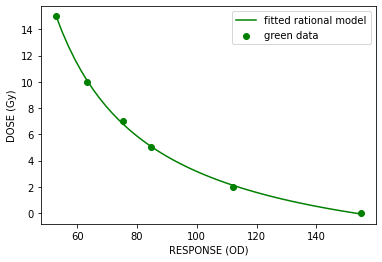

In [8]:
print("GREEN POINTS CURVE")
print()

p0 = -10., 300., 3. #da cambiare eventualmente il punto iniziale

poptGreen = curve_fit(rational, calibration_dose, calibration_green, p0, maxfev=1000)[0]
plt.scatter(calibration_dose, calibration_green, color='green', label='green data')
plt.plot(d, rational(d, *poptGreen), 'g-', label='fitted rational model')
plt.xlabel("DOSE (Gy)")
plt.ylabel("RESPONSE (OD)")
plt.legend(loc='upper right')
plt.show()

r = np.linspace(np.min(calibration_green), np.max(calibration_green))

p0 = -10., 300., 3. #da cambiare eventualmente il punto iniziale

poptGreenInverse = curve_fit(rational_inverse, calibration_green, calibration_dose, p0, maxfev=1000)[0]
plt.scatter(calibration_green, calibration_dose, color='green', label='green data')
plt.plot(r, rational_inverse(r, *poptGreenInverse), 'g-', label='fitted rational model')
plt.xlabel("RESPONSE (OD)")
plt.ylabel("DOSE (Gy)")
plt.legend(loc='upper right')
plt.show()

BLUE POINTS CURVE



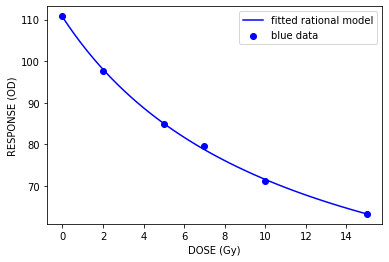

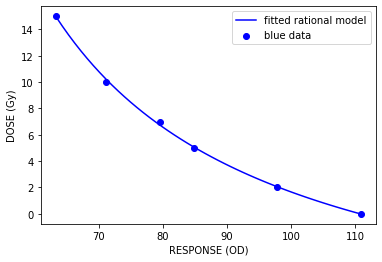

In [9]:
print("BLUE POINTS CURVE")
print()

p0 = -10., 300., 3. #da cambiare eventualmente il punto iniziale

poptBlue = curve_fit(rational, calibration_dose, calibration_blue, p0, maxfev=1000)[0]
plt.scatter(calibration_dose, calibration_blue, color='blue', label='blue data')
plt.plot(d, rational(d, *poptBlue), 'b-', label='fitted rational model')
plt.xlabel("DOSE (Gy)")
plt.ylabel("RESPONSE (OD)")
plt.legend(loc='upper right')
plt.show()

r = np.linspace(np.min(calibration_blue), np.max(calibration_blue))

p0 = -10., 300., 3. #da cambiare eventualmente il punto iniziale

poptBlueInverse = curve_fit(rational_inverse, calibration_blue, calibration_dose, p0, maxfev=1000)[0]
plt.scatter(calibration_blue, calibration_dose, color='blue', label='blue data')
plt.plot(r, rational_inverse(r, *poptBlueInverse), 'b-', label='fitted rational model')
plt.xlabel("RESPONSE (OD)")
plt.ylabel("DOSE (Gy)")
plt.legend(loc='upper right')
plt.show()

THREE CHANNEL CURVE

`xtol` termination condition is satisfied.
Function evaluations 24, initial cost 5.5144e+01, final cost 3.6859e+01, first-order optimality 1.38e+00.


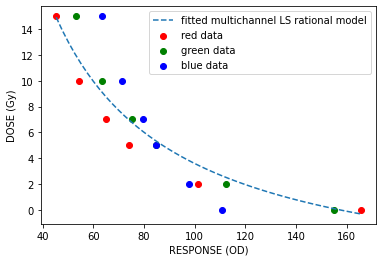

`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 4.2372e+04, final cost 1.1506e+03, first-order optimality 1.43e-04.


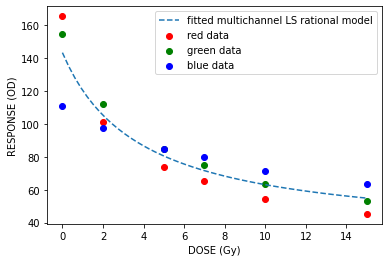

In [10]:
print("THREE CHANNEL CURVE")
print()

xi = np.append(np.asanyarray(calibration_red), np.asanyarray(calibration_green))
x = np.append(xi, np.asanyarray(calibration_blue))

yi = np.append(np.asanyarray(calibration_dose), np.asanyarray(calibration_dose))
y = np.append(yi, np.asanyarray(calibration_dose))

a0 = np.array([0, 1000, 5]) #da cambiare eventualmente

fitResults_inv = least_squares(multichannel_function_inverse, a0, jac=jac_inverse, method='lm', args=(x, y), max_nfev=1000000000, verbose=1)
fitResults_inv.x

x_calibration_fit = np.linspace(min(x), max(x))
y_calibration_fit = multichannel_model_inverse(fitResults_inv.x, x_calibration_fit)
plt.scatter(calibration_red, calibration_dose, color='red', label='red data')
plt.scatter(calibration_green, calibration_dose,color='green', label='green data')
plt.scatter(calibration_blue, calibration_dose, color='blue', label='blue data')
plt.plot(x_calibration_fit, y_calibration_fit, label='fitted multichannel LS rational model', ls='dashed')
plt.xlabel("RESPONSE (OD)")
plt.ylabel("DOSE (Gy)")
plt.legend(loc='upper right')
plt.show()

xi = np.append(np.asanyarray(calibration_dose), np.asanyarray(calibration_dose))
x = np.append( xi, np.asanyarray(calibration_dose))

yi = np.append(np.asanyarray(calibration_red), np.asanyarray(calibration_green))
y = np.append( yi, np.asanyarray(calibration_blue))

a0 = np.array([-10, 200, 3]) #da cambiare eventualmente

fitResults = least_squares(multichannel_function, a0, jac=jac, args=(x, y), verbose=1)
fitResults.x

x_max_lsmodel = max(x)
x_calibration_fit = np.linspace(0, x_max_lsmodel)
y_calibration_fit = multichannel_model(fitResults.x, x_calibration_fit)
x_calibration_fit_shrink = np.linspace(0, maxdoseRecalibration)
y_calibration_fit_shrink = multichannel_model(fitResults.x, x_calibration_fit_shrink)
plt.scatter(calibration_dose, calibration_red, color='red', label='red data')
plt.scatter(calibration_dose, calibration_green, color='green', label='green data')
plt.scatter(calibration_dose, calibration_blue, color='blue', label='blue data')
plt.plot(x_calibration_fit, y_calibration_fit, label='fitted multichannel LS rational model', ls='dashed')
plt.xlabel("DOSE (Gy)")
plt.ylabel("RESPONSE (OD)")
plt.legend(loc='upper right')
plt.show()

TREATMENT NUMBER  1

 filepath = scansPoli/TREATMENT/treatment_4XY.tif

 RED: min, mean, max, std predicted dose = 4.4, 4.6, 4.8 Gy, 0.1 Gy
 GREEN: min, mean, max, std predicted dose = 4.1, 4.3, 4.3 Gy, 0.1 Gy
 BLUE: min, mean, max, std predicted dose = 3.8, 4.0, 4.5 Gy, 0.2 Gy
 3 CHANNEL WEIGHTED: min, mean, max, std predicted dose = 4.1, 4.3, 4.5 Gy, 0.1 Gy



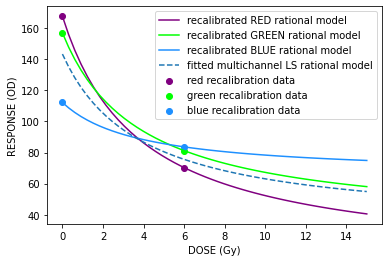

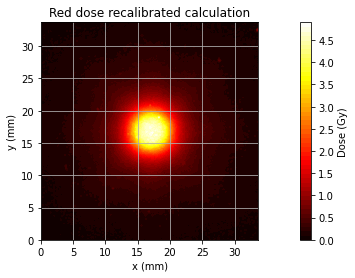

Analytical FWHM of red x dose: 6.77 mm
Analytical FWHM of red y dose: 6.77 mm


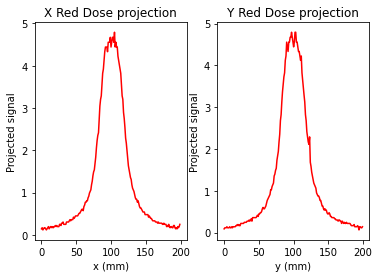

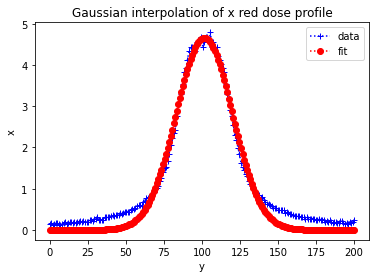

Gaussian FWHM of x red dose profile: 7.36 mm


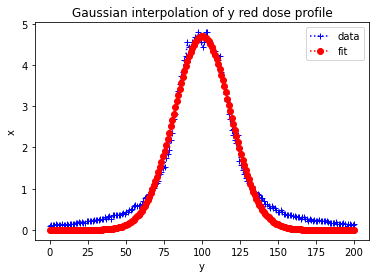

Gaussian FWHM of y red dose profile: 7.41 mm


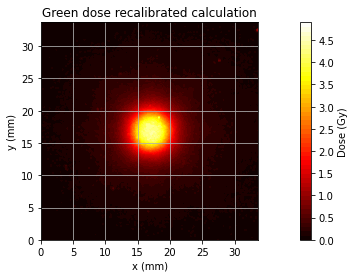

Analytical FWHM of green x dose: 6.1 mm
Analytical FWHM of green y dose: 6.27 mm


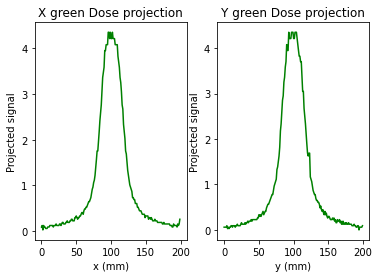

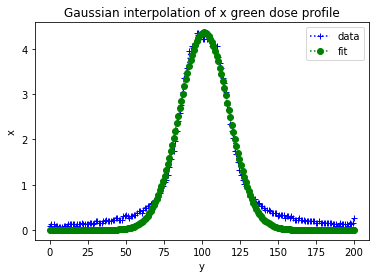

Gaussian FWHM of x green dose profile: 6.46 mm


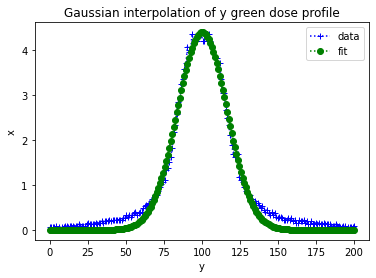

Gaussian FWHM of y green dose profile: 6.5 mm


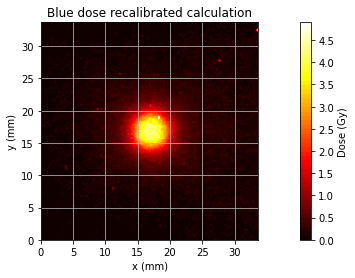

Analytical FWHM of blue x dose: 5.59 mm
Analytical FWHM of blue y dose: 5.59 mm


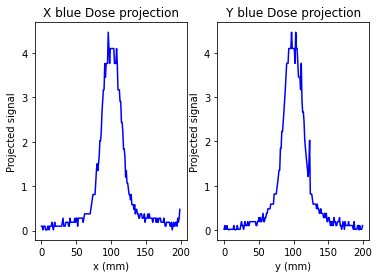

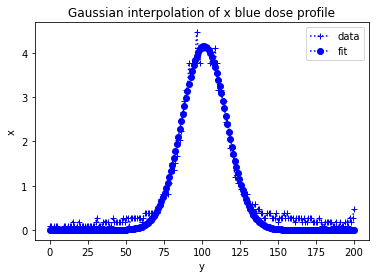

Gaussian FWHM of x blue dose profile: 5.79 mm


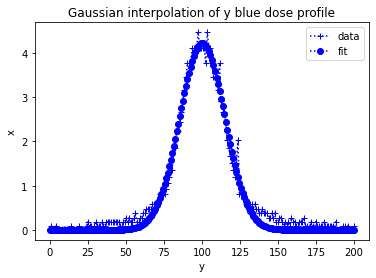

Gaussian FWHM of y blue dose profile: 5.89 mm


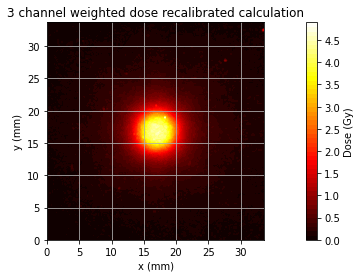

<Figure size 432x288 with 0 Axes>

Analytical FWHM of 3channel x dose: 6.1 mm
Analytical FWHM of 3channel y dose: 6.27 mm


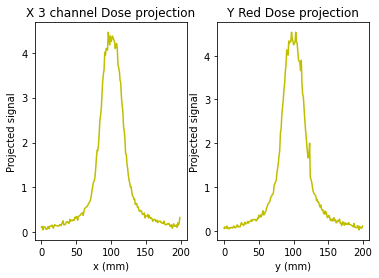

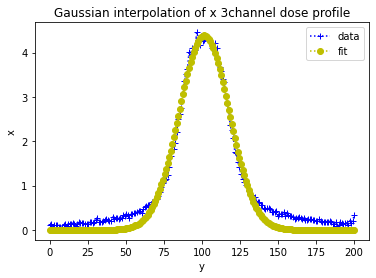

Gaussian FWHM of x 3channel dose profile: 6.56 mm


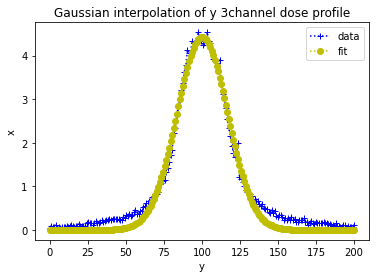

Gaussian FWHM of y 3channel dose profile: 6.62 mm
TREATMENT NUMBER  2

 filepath = scansPoli/TREATMENT/treatment_8XZ.tif

 RED: min, mean, max, std predicted dose = 4.3, 4.6, 4.8 Gy, 0.1 Gy
 GREEN: min, mean, max, std predicted dose = 3.9, 4.1, 4.2 Gy, 0.1 Gy
 BLUE: min, mean, max, std predicted dose = 3.0, 3.2, 3.3 Gy, 0.1 Gy
 3 CHANNEL WEIGHTED: min, mean, max, std predicted dose = 3.8, 4.0, 4.1 Gy, 0.1 Gy



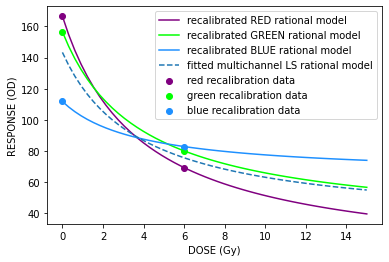

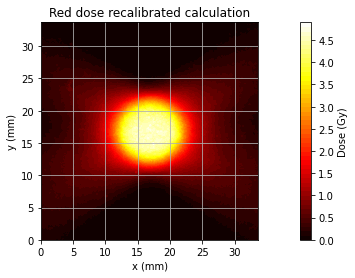

Analytical FWHM of red x dose: 11.35 mm
Analytical FWHM of red y dose: 10.33 mm


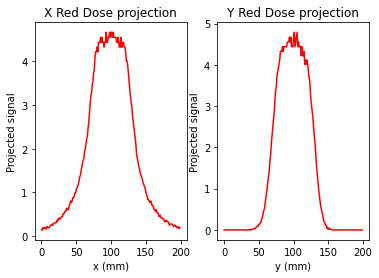

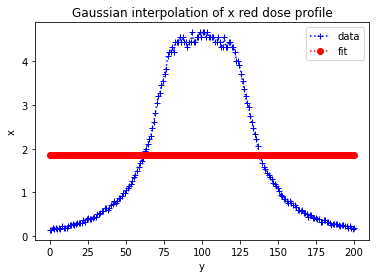

Gaussian FWHM of x red dose profile: 479691045.03 mm


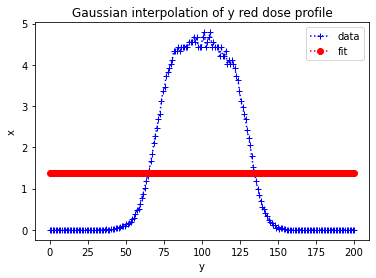

Gaussian FWHM of y red dose profile: 462909.34 mm


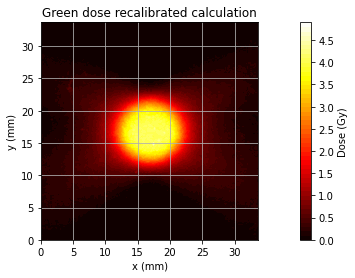

Analytical FWHM of green x dose: 10.5 mm
Analytical FWHM of green y dose: 9.65 mm


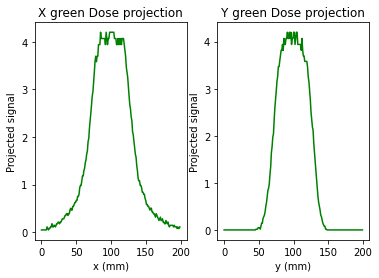

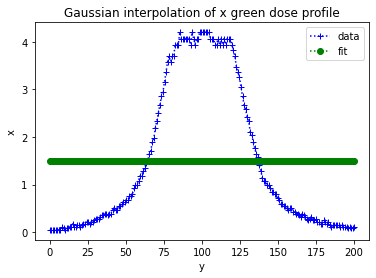

Gaussian FWHM of x green dose profile: 46572245.05 mm


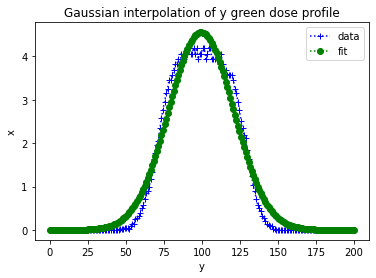

Gaussian FWHM of y green dose profile: 8.54 mm


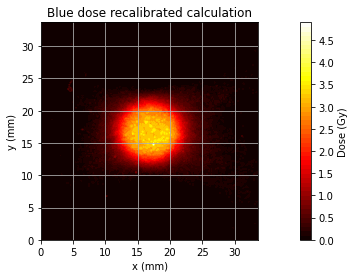

Analytical FWHM of blue x dose: 9.82 mm
Analytical FWHM of blue y dose: 8.81 mm


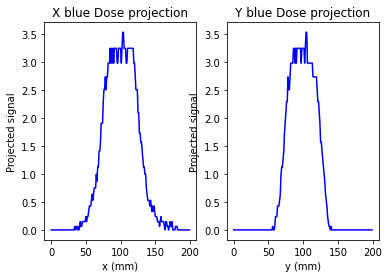

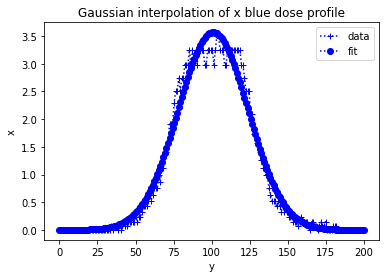

Gaussian FWHM of x blue dose profile: 9.19 mm


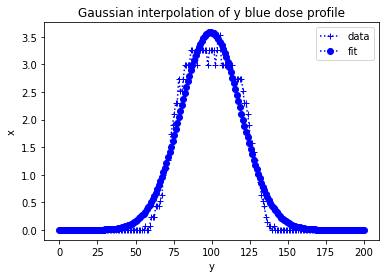

Gaussian FWHM of y blue dose profile: 7.86 mm


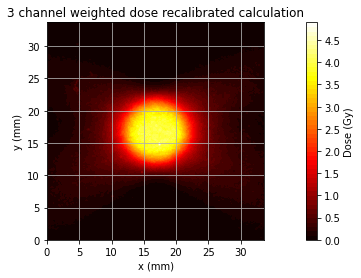

<Figure size 432x288 with 0 Axes>

Analytical FWHM of 3channel x dose: 10.67 mm
Analytical FWHM of 3channel y dose: 9.65 mm


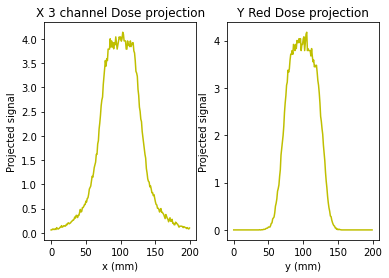

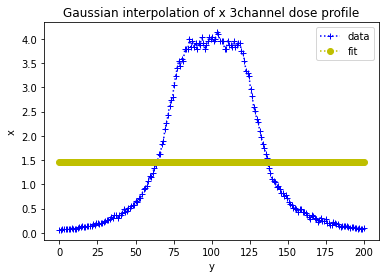

Gaussian FWHM of x 3channel dose profile: 12619937.84 mm


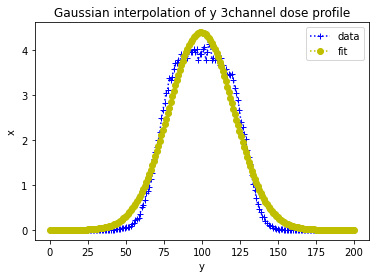

Gaussian FWHM of y 3channel dose profile: 8.55 mm
TREATMENT NUMBER  3

 filepath = scansPoli/TREATMENT/treatment_8XY.tif

 RED: min, mean, max, std predicted dose = 4.3, 4.6, 4.8 Gy, 0.1 Gy
 GREEN: min, mean, max, std predicted dose = 4.1, 4.2, 4.4 Gy, 0.1 Gy
 BLUE: min, mean, max, std predicted dose = 3.3, 3.5, 3.8 Gy, 0.2 Gy
 3 CHANNEL WEIGHTED: min, mean, max, std predicted dose = 3.9, 4.1, 4.3 Gy, 0.1 Gy



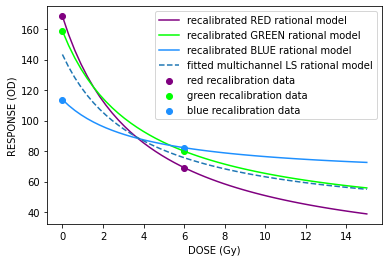

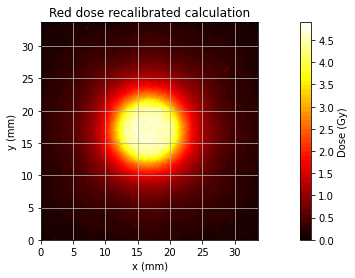

Analytical FWHM of red x dose: 11.68 mm
Analytical FWHM of red y dose: 11.68 mm


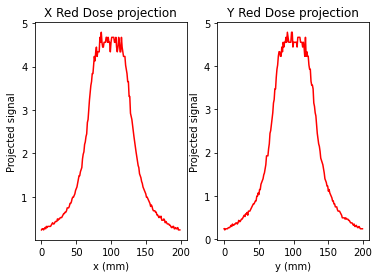

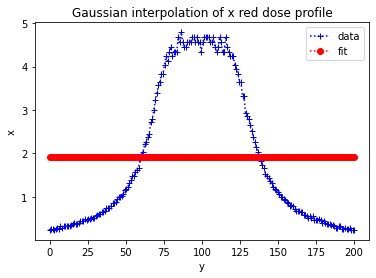

Gaussian FWHM of x red dose profile: 263833658.6 mm


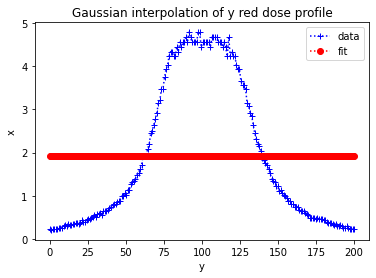

Gaussian FWHM of y red dose profile: 18915268.84 mm


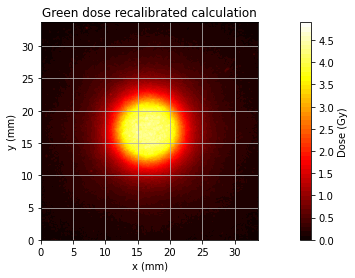

Analytical FWHM of green x dose: 11.01 mm
Analytical FWHM of green y dose: 10.84 mm


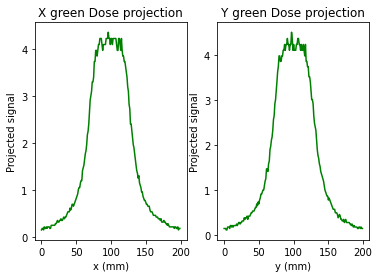

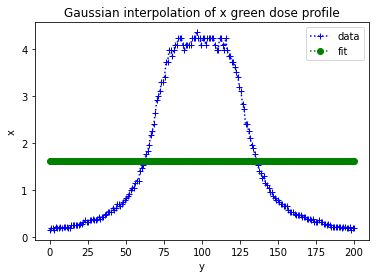

Gaussian FWHM of x green dose profile: 62650389.26 mm


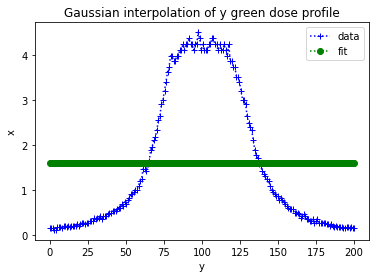

Gaussian FWHM of y green dose profile: 155976194.04 mm


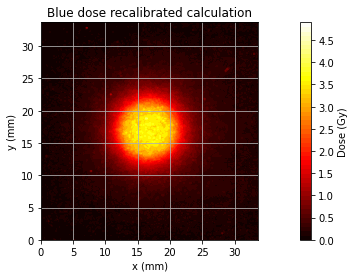

Analytical FWHM of blue x dose: 10.33 mm
Analytical FWHM of blue y dose: 9.99 mm


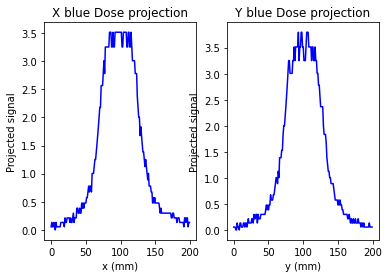

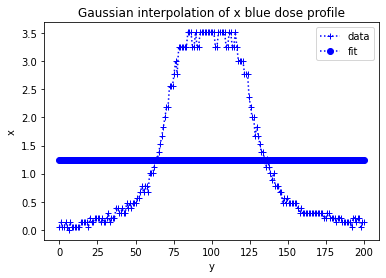

Gaussian FWHM of x blue dose profile: 405487.71 mm


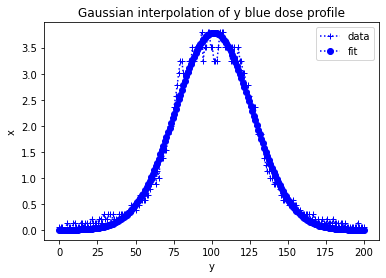

Gaussian FWHM of y blue dose profile: 10.06 mm


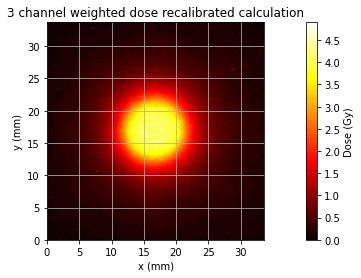

<Figure size 432x288 with 0 Axes>

Analytical FWHM of 3channel x dose: 11.01 mm
Analytical FWHM of 3channel y dose: 11.01 mm


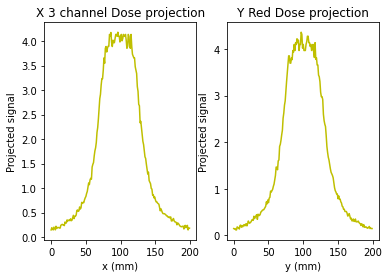

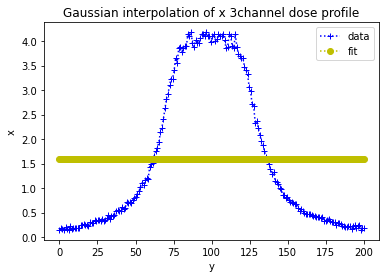

Gaussian FWHM of x 3channel dose profile: 22013621.85 mm


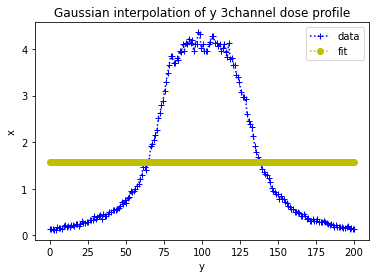

Gaussian FWHM of y 3channel dose profile: 133287907.54 mm
TREATMENT NUMBER  4

 filepath = scansPoli/TREATMENT/treatment_4XZ.tif

 RED: min, mean, max, std predicted dose = 4.5, 4.6, 4.7 Gy, 0.1 Gy
 GREEN: min, mean, max, std predicted dose = 4.1, 4.3, 4.4 Gy, 0.1 Gy
 BLUE: min, mean, max, std predicted dose = 3.9, 4.2, 4.5 Gy, 0.2 Gy
 3 CHANNEL WEIGHTED: min, mean, max, std predicted dose = 4.1, 4.4, 4.5 Gy, 0.1 Gy



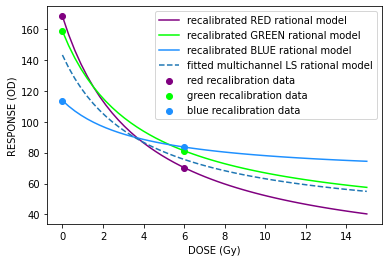

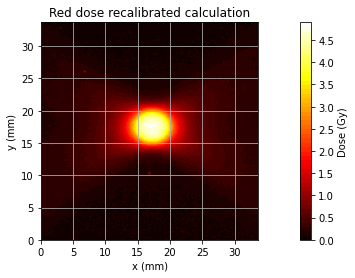

Analytical FWHM of red x dose: 6.6 mm
Analytical FWHM of red y dose: 5.42 mm


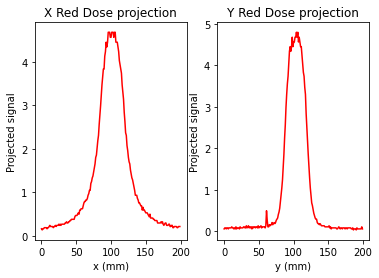

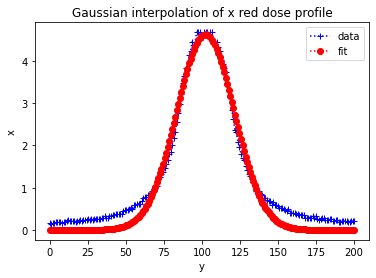

Gaussian FWHM of x red dose profile: 7.54 mm


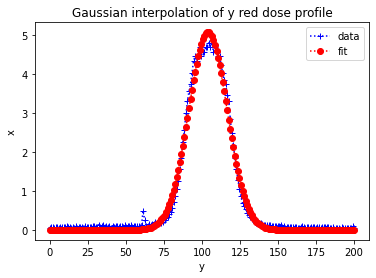

Gaussian FWHM of y red dose profile: 5.04 mm


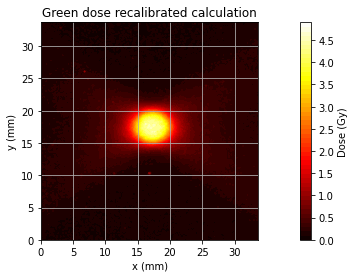

Analytical FWHM of green x dose: 5.93 mm
Analytical FWHM of green y dose: 5.08 mm


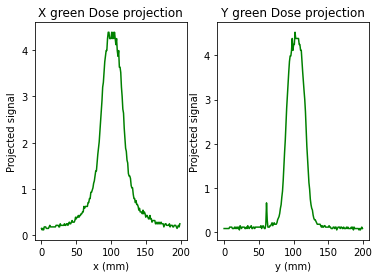

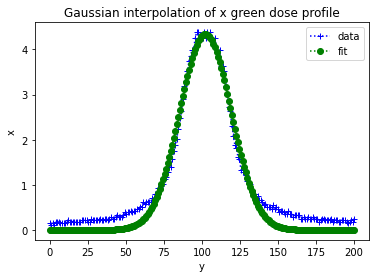

Gaussian FWHM of x green dose profile: 6.74 mm


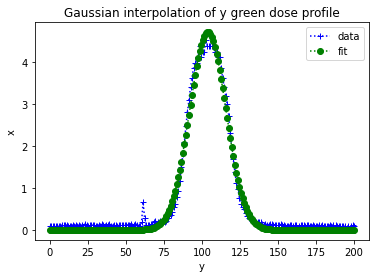

Gaussian FWHM of y green dose profile: 4.75 mm


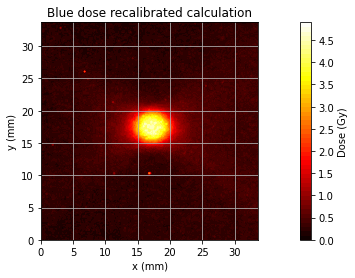

Analytical FWHM of blue x dose: 5.76 mm
Analytical FWHM of blue y dose: 4.91 mm


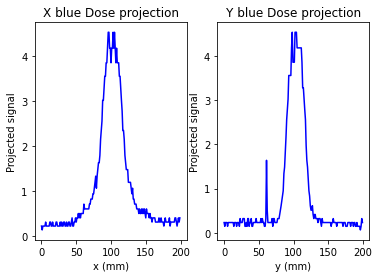

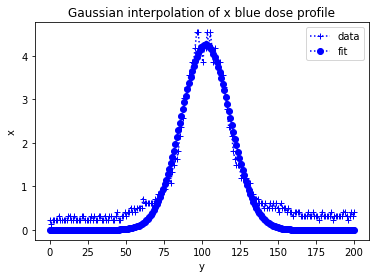

Gaussian FWHM of x blue dose profile: 6.43 mm


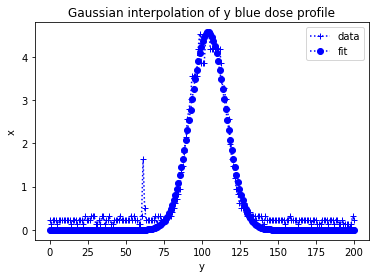

Gaussian FWHM of y blue dose profile: 4.62 mm


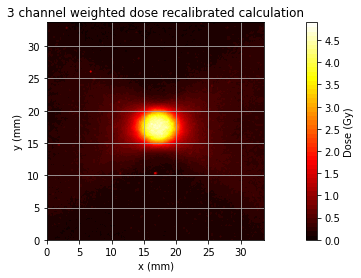

<Figure size 432x288 with 0 Axes>

Analytical FWHM of 3channel x dose: 6.1 mm
Analytical FWHM of 3channel y dose: 5.08 mm


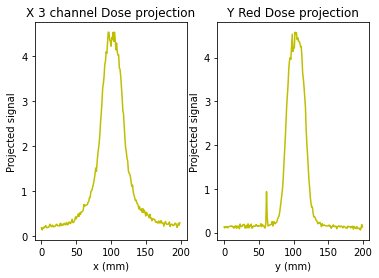

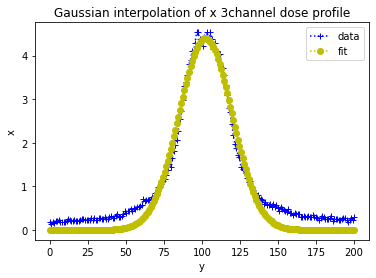

Gaussian FWHM of x 3channel dose profile: 6.94 mm


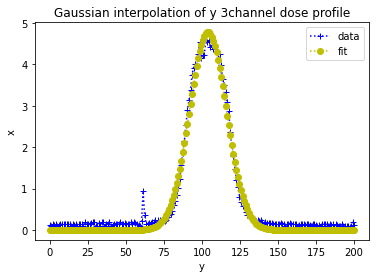

Gaussian FWHM of y 3channel dose profile: 4.82 mm
TREATMENT NUMBER  5

 filepath = scansPoli/TREATMENT/treatment_16XY.tif

 RED: min, mean, max, std predicted dose = 5.0, 5.1, 5.2 Gy, 0.1 Gy
 GREEN: min, mean, max, std predicted dose = 4.6, 4.8, 4.9 Gy, 0.1 Gy
 BLUE: min, mean, max, std predicted dose = 4.1, 4.2, 4.5 Gy, 0.1 Gy
 3 CHANNEL WEIGHTED: min, mean, max, std predicted dose = 4.6, 4.7, 4.9 Gy, 0.1 Gy



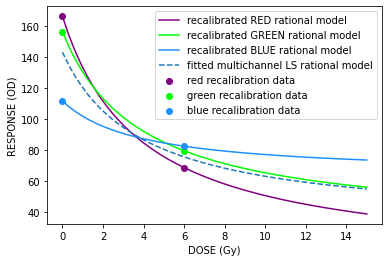

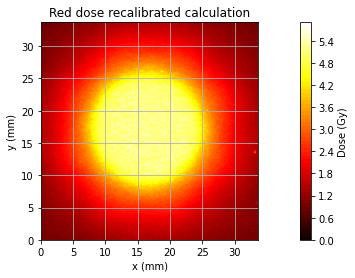

Analytical FWHM of red x dose: 20.66 mm
Analytical FWHM of red y dose: 20.66 mm


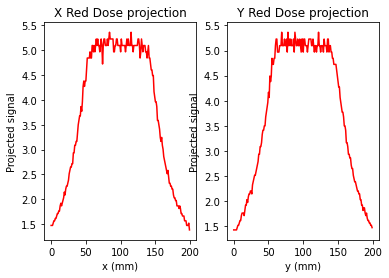

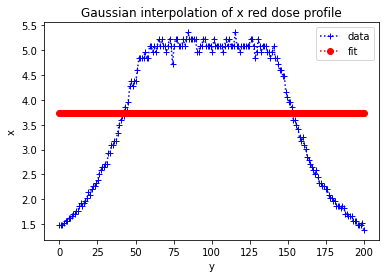

Gaussian FWHM of x red dose profile: 68745133229.98 mm


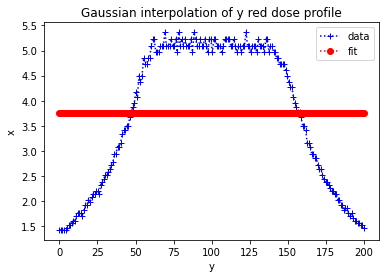

Gaussian FWHM of y red dose profile: 688589618337.17 mm


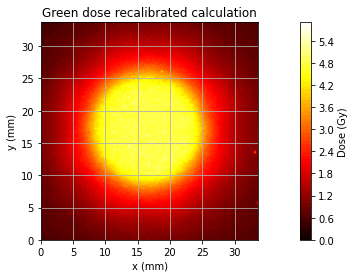

Analytical FWHM of green x dose: 19.81 mm
Analytical FWHM of green y dose: 20.15 mm


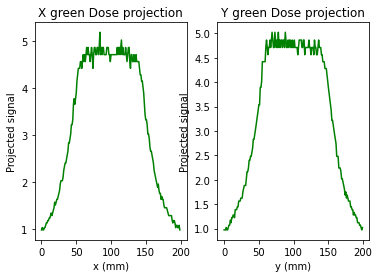

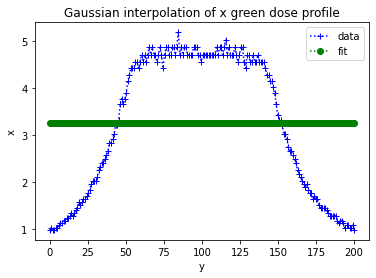

Gaussian FWHM of x green dose profile: 113131636971.86 mm


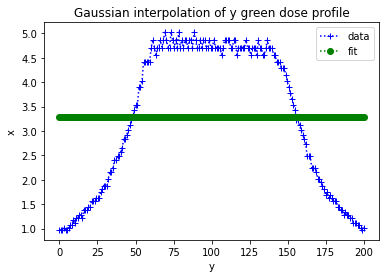

Gaussian FWHM of y green dose profile: 45999010773.08 mm


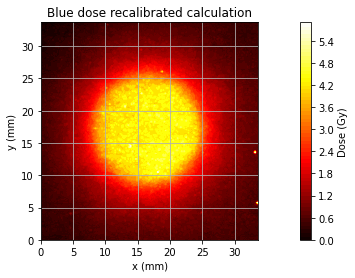

Analytical FWHM of blue x dose: 18.46 mm
Analytical FWHM of blue y dose: 19.47 mm


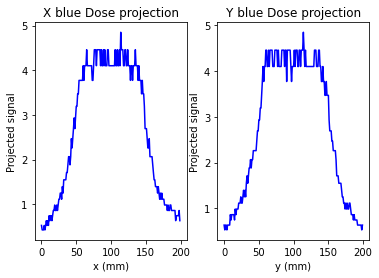

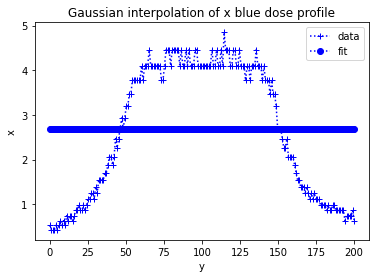

Gaussian FWHM of x blue dose profile: 55255527836.02 mm


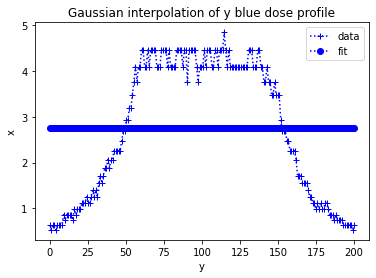

Gaussian FWHM of y blue dose profile: 38233810416.34 mm


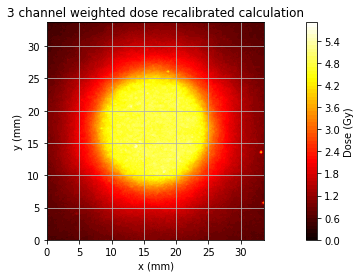

<Figure size 432x288 with 0 Axes>

Analytical FWHM of 3channel x dose: 19.81 mm
Analytical FWHM of 3channel y dose: 20.15 mm


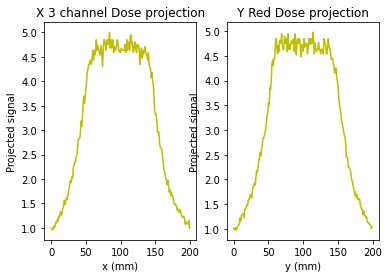

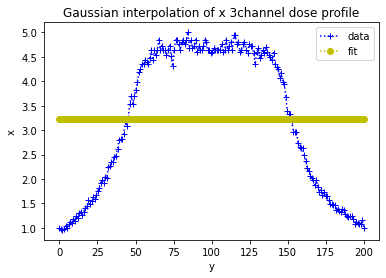

Gaussian FWHM of x 3channel dose profile: 207990916182.08 mm


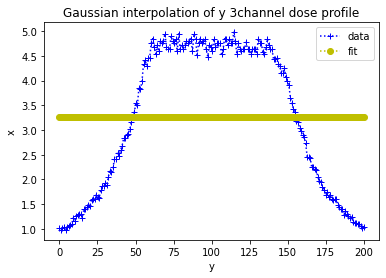

Gaussian FWHM of y 3channel dose profile: 50543514624.45 mm
TREATMENT NUMBER  6

 filepath = scansPoli/TREATMENT/treatment_16XZ.tif

 RED: min, mean, max, std predicted dose = 5.0, 5.3, 5.5 Gy, 0.2 Gy
 GREEN: min, mean, max, std predicted dose = 4.7, 5.0, 5.2 Gy, 0.1 Gy
 BLUE: min, mean, max, std predicted dose = 4.4, 4.5, 5.1 Gy, 0.2 Gy
 3 CHANNEL WEIGHTED: min, mean, max, std predicted dose = 4.7, 4.9, 5.2 Gy, 0.1 Gy



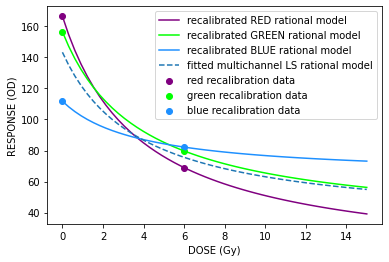

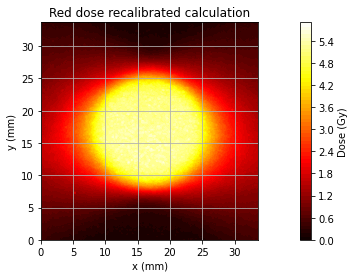

Analytical FWHM of red x dose: 21.67 mm
Analytical FWHM of red y dose: 17.95 mm


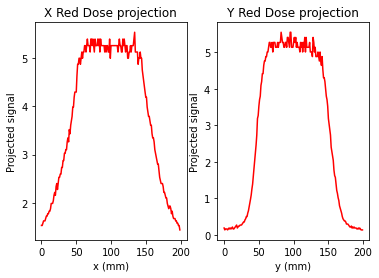

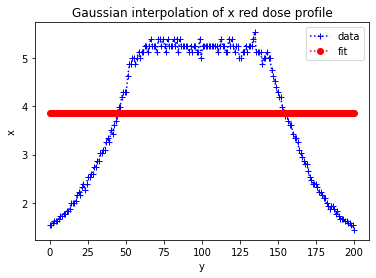

Gaussian FWHM of x red dose profile: 1953629491493.93 mm


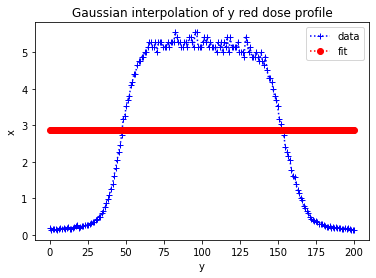

Gaussian FWHM of y red dose profile: 110918661.22 mm


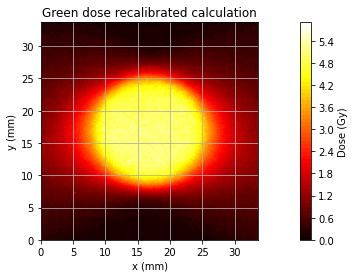

Analytical FWHM of green x dose: 20.15 mm
Analytical FWHM of green y dose: 17.44 mm


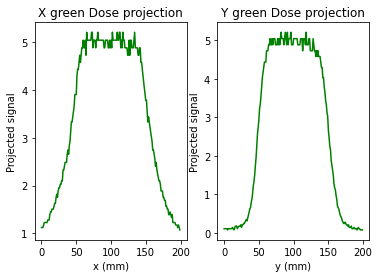

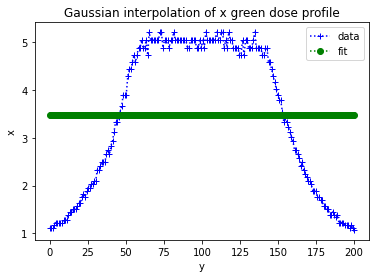

Gaussian FWHM of x green dose profile: 296988102719.42 mm


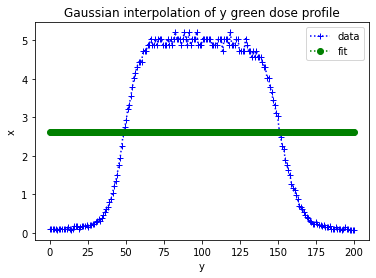

Gaussian FWHM of y green dose profile: 4706288283.32 mm


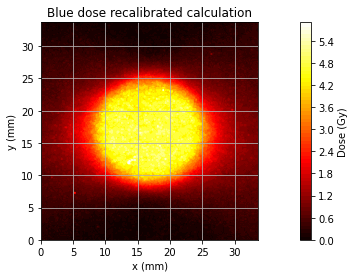

Analytical FWHM of blue x dose: 19.64 mm
Analytical FWHM of blue y dose: 16.59 mm


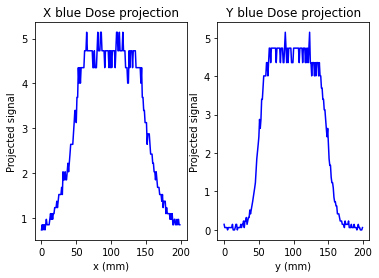

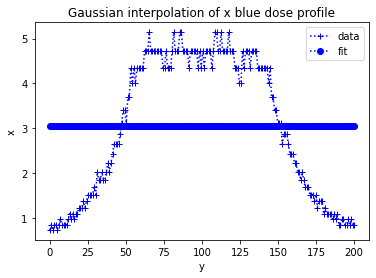

Gaussian FWHM of x blue dose profile: 41929273642.02 mm


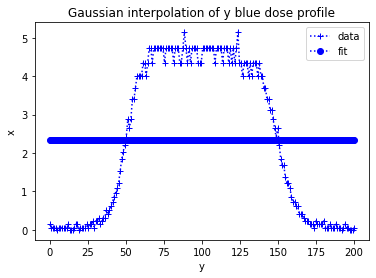

Gaussian FWHM of y blue dose profile: 1209206269.68 mm


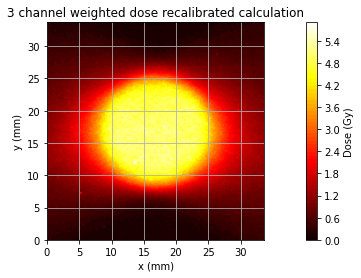

<Figure size 432x288 with 0 Axes>

Analytical FWHM of 3channel x dose: 20.32 mm
Analytical FWHM of 3channel y dose: 17.44 mm


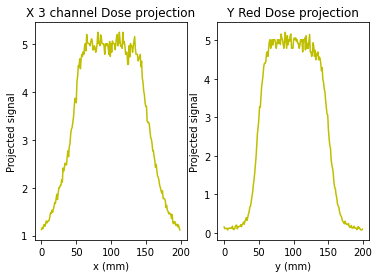

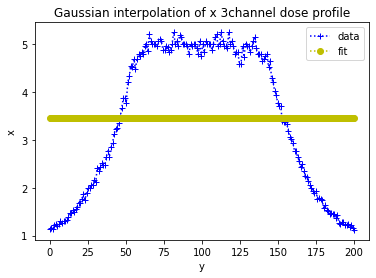

Gaussian FWHM of x 3channel dose profile: 325985228383.57 mm


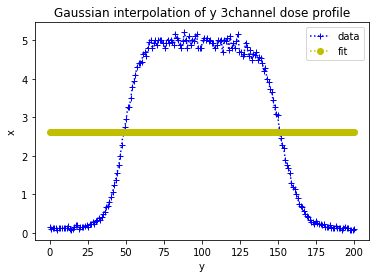

Gaussian FWHM of y 3channel dose profile: 28419146142.54 mm


In [11]:
outputPath = path + 'OUTPUT'

files = gb.glob(outputPath +'/RED/*')
for f in files:
    os.remove(f)
files = gb.glob(outputPath +'/GREEN/*')
for f in files:
    os.remove(f)
files = gb.glob(outputPath +'/BLUE/*')
for f in files:
    os.remove(f)
files = gb.glob(outputPath +'/3CH/*')
for f in files:
    os.remove(f)


for i, scan_filepath in enumerate(treatment_list):  
    #startString()

    unexposed_treatment_filepath = unexposed_treatment_list[i]
    maxdose_treatment_filepath = maxdose_treatment_list[i]
    image = cv2.imread(scan_filepath)
    netImage = image #unexposed_treatment_image
    xshape= int(netImage.shape[0]/2)
    yshape= int(netImage.shape[1]/2)
    
    unexposed_treatment_image = cv2.imread(unexposed_treatment_filepath)
    #zero_dose_red = multichannel_model_inverse(fitResults_inv.x, zero_response_red)
    zero_response_red = np.mean(unexposed_treatment_image[xshape-5:xshape+5,yshape-5:yshape+5,redChannel])
    zero_response_green = np.mean(unexposed_treatment_image[xshape-5:xshape+5,yshape-5:yshape+5,greenChannel])
    zero_response_blue = np.mean(unexposed_treatment_image[xshape-5:xshape+5,yshape-5:yshape+5,blueChannel])
    
    maxdose_treatment_image = cv2.imread(maxdose_treatment_filepath)
    #maxdose_dose_red = multichannel_model_inverse(fitResults_inv.x, maxdose_response_red)
    maxdose_response_red = np.mean(maxdose_treatment_image[xshape-5:xshape+5,yshape-5:yshape+5,redChannel])
    maxdose_response_green = np.mean(maxdose_treatment_image[xshape-5:xshape+5,yshape-5:yshape+5,greenChannel])
    maxdose_response_blue = np.mean(maxdose_treatment_image[xshape-5:xshape+5,yshape-5:yshape+5,blueChannel])
            
    a_red = calibration_factors_calculator(zero_response_red, maxdose_response_red)[0]  
    b_red = calibration_factors_calculator(zero_response_red, maxdose_response_red)[1]  
    a_green = calibration_factors_calculator(zero_response_green, maxdose_response_green)[0]  
    b_green = calibration_factors_calculator(zero_response_green, maxdose_response_green)[1]  
    a_blue = calibration_factors_calculator(zero_response_blue, maxdose_response_blue)[0]  
    b_blue = calibration_factors_calculator(zero_response_blue, maxdose_response_blue)[1]  
    
    def recalibrated_multichannel_response_curve_red(x):
        return a_red + b_red*multichannel_model(fitResults.x, x)
    def recalibrated_multichannel_response_curve_green(x):
        return a_green + b_green*multichannel_model(fitResults.x, x)    
    def recalibrated_multichannel_response_curve_blue(x):
        return a_blue + b_blue*multichannel_model(fitResults.x, x)
    
    inverse_recalibrated_multichannel_response_curve_red = inversefunc(recalibrated_multichannel_response_curve_red)
    inverse_recalibrated_multichannel_response_curve_green = inversefunc(recalibrated_multichannel_response_curve_green)
    inverse_recalibrated_multichannel_response_curve_blue = inversefunc(recalibrated_multichannel_response_curve_blue)

    print("TREATMENT NUMBER " , i+1)
    print()
    print(" filepath = %s" % (scan_filepath))
    print()
    #red
    #filtered_red = medfilt(wiener(netImage[:,:,redChannel])[-1:1:-1,1:-1])[1:-1,1:-1]
    #dose_red = inverse_recalibrated_multichannel_response_curve_red(filtered_red) #inverso del filtrato
    dose_red = inverse_recalibrated_multichannel_response_curve_red(netImage[:,:,redChannel])
    dose_red = dose_red.clip(min=0)
    dose_red_shapex = dose_red.shape[0]
    dose_red_shapey = dose_red.shape[1]
    dose_red_center = dose_red[int(dose_red_shapex/2) - int(dimensioneRoiPixel/2) : int(dose_red_shapex/2) + int(dimensioneRoiPixel/2),
                               int(dose_red_shapey/2) - int(dimensioneRoiPixel/2) : int(dose_red_shapey/2) + int(dimensioneRoiPixel/2)]
    dose_red_background_mean_x = np.mean(dose_red[0 : int(dose_red_shapex), 0 : 5])
    dose_red_background_mean_y = np.mean(dose_red[0 : 5, 0 : int(dose_red_shapey)])
    max_red = np.max(dose_red_center)
    avg_red = np.mean(dose_red_center)
    min_red = np.min(dose_red_center)
    std_red = np.std(dose_red_center)
    half_maximum_red_x = (avg_red + dose_red_background_mean_x)/2
    half_maximum_red_y = (avg_red + dose_red_background_mean_y)/2
    print(" RED: min, mean, max, std predicted dose = %0.01f, %0.01f, %0.01f Gy, %0.01f Gy" % (min_red, avg_red, max_red, std_red))
    #green
    #filtered_green = medfilt(wiener(netImage[:,:,greenChannel])[-1:1:-1,1:-1])[1:-1,1:-1]
    #dose_green = inverse_recalibrated_multichannel_response_curve_green(filtered_green) 
    dose_green = inverse_recalibrated_multichannel_response_curve_green(netImage[:,:,greenChannel])
    dose_green = dose_green.clip(min=0)
    dose_green_shapex = dose_green.shape[0]
    dose_green_shapey = dose_green.shape[1]
    dose_green_center = dose_green[int(dose_green_shapex/2) - int(dimensioneRoiPixel/2) : int(dose_green_shapex/2) + int(dimensioneRoiPixel/2),
                                   int(dose_green_shapey/2) - int(dimensioneRoiPixel/2) : int(dose_green_shapey/2) + int(dimensioneRoiPixel/2)]
    dose_green_background_mean_x = np.mean(dose_green[0 : int(dose_green_shapex), 0 : 5])
    dose_green_background_mean_y = np.mean(dose_green[0 : 5, 0 : int(dose_green_shapey)])
    max_green = np.max(dose_green_center)
    avg_green = np.mean(dose_green_center)
    min_green = np.min(dose_green_center)
    std_green = np.std(dose_green_center)
    half_maximum_green_y = (avg_green + dose_green_background_mean_y)/2
    half_maximum_green_x = (avg_green + dose_green_background_mean_x)/2
    print(" GREEN: min, mean, max, std predicted dose = %0.01f, %0.01f, %0.01f Gy, %0.01f Gy" % (min_green, avg_green, max_green, std_green ))
    #blue
    #filtered_blue = medfilt(wiener(netImage[:,:,blueChannel])[-1:1:-1,1:-1])[1:-1,1:-1] 
    #dose_blue = inverse_recalibrated_multichannel_response_curve_blue(filtered_blue)
    dose_blue = inverse_recalibrated_multichannel_response_curve_blue(netImage[:,:,blueChannel])
    dose_blue = dose_blue.clip(min=0)
    dose_blue_shapex = dose_blue.shape[0]
    dose_blue_shapey = dose_blue.shape[1]
    dose_blue_center = dose_blue[int(dose_blue_shapex/2) - int(dimensioneRoiPixel/2) : int(dose_blue_shapex/2) + int(dimensioneRoiPixel/2),
                                int(dose_blue_shapey/2) - int(dimensioneRoiPixel/2) : int(dose_blue_shapey/2) + int(dimensioneRoiPixel/2)]
    dose_blue_background_mean_x = np.mean(dose_blue[0 : int(dose_blue_shapex), 0 : 5])
    dose_blue_background_mean_y = np.mean(dose_blue[0 : 5, 0 : int(dose_blue_shapey)])
    max_blue = np.max(dose_blue_center)
    avg_blue = np.mean(dose_blue_center)
    min_blue = np.min(dose_blue_center) 
    std_blue = np.std(dose_blue_center)
    half_maximum_blue_y = (avg_blue + dose_blue_background_mean_y)/2
    half_maximum_blue_x = (avg_blue + dose_blue_background_mean_x)/2
    print(" BLUE: min, mean, max, std predicted dose = %0.01f, %0.01f, %0.01f Gy, %0.01f Gy" % (min_blue, avg_blue, max_blue, std_blue ))
    #3 channel
    dose_3ch = (dose_blue_center + dose_red_center + dose_green_center)/3
    dose_3ch_background_mean_x = (dose_red_background_mean_x + dose_green_background_mean_x + dose_blue_background_mean_x)/3
    dose_3ch_background_mean_y = (dose_red_background_mean_y + dose_green_background_mean_y + dose_blue_background_mean_y)/3
    max_3ch = np.max(dose_3ch)
    avg_3ch = np.mean(dose_3ch)
    min_3ch = np.min(dose_3ch)  
    std_3ch = np.std(dose_3ch)
    half_maximum_3ch_x = (avg_3ch + dose_3ch_background_mean_x)/2
    half_maximum_3ch_y = (avg_3ch + dose_3ch_background_mean_y)/2
    print(" 3 CHANNEL WEIGHTED: min, mean, max, std predicted dose = %0.01f, %0.01f, %0.01f Gy, %0.01f Gy" % (min_3ch, avg_3ch, max_3ch, std_3ch ))
    print()
    
    x_calibration_fit = np.linspace(0, x_max_lsmodel)
    y_calibration_fit_red = recalibrated_multichannel_response_curve_red(x_calibration_fit)
    y_calibration_fit_green = recalibrated_multichannel_response_curve_green(x_calibration_fit)
    y_calibration_fit_blue = recalibrated_multichannel_response_curve_blue(x_calibration_fit)
    plt.scatter(0, zero_response_red, color='purple', label='red recalibration data')
    plt.scatter(0, zero_response_green, color='lime', label='green recalibration data')
    plt.scatter(0, zero_response_blue, color='dodgerblue', label='blue recalibration data')
    plt.scatter(maxdoseRecalibration, maxdose_response_red, color='purple')
    plt.scatter(maxdoseRecalibration, maxdose_response_green, color='lime')
    plt.scatter(maxdoseRecalibration, maxdose_response_blue, color='dodgerblue')
    plt.plot(x_calibration_fit, y_calibration_fit_red, 'purple', label='recalibrated RED rational model')
    plt.plot(x_calibration_fit, y_calibration_fit_green, 'lime', label='recalibrated GREEN rational model')
    plt.plot(x_calibration_fit, y_calibration_fit_blue, 'dodgerblue', label= 'recalibrated BLUE rational model')
    plt.plot(x_calibration_fit, y_calibration_fit, label='fitted multichannel LS rational model', ls='dashed')
    #plt.scatter(calibration_dose, calibration_red, color='red')
    #plt.scatter(calibration_dose, calibration_green, color='green')
    #plt.scatter(calibration_dose, calibration_blue, color='blue')
    plt.xlabel("DOSE (Gy)")
    plt.ylabel("RESPONSE (OD)")
    plt.legend(loc='upper right')
    plt.show()

    shape = np.shape(dose_red)
    x = np.arange(shape[1])*dpiResolution
    y = np.arange(shape[0])*dpiResolution
    xx, yy = np.meshgrid(x, y)
    levels = np.arange(0, int(math.ceil(max(max_red,max_green,max_blue)+isodoseDifferenceGy)), isodoseDifferenceGy)
    
    plt.figure()
    c = plt.contourf(xx, yy, dose_red, cmap='hot', levels=levels)
    plt.colorbar(c, label="Dose (Gy)")
    plt.title("Red dose recalibrated calculation")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("scaled")
    plt.grid(True)
    plt.savefig(outputPath + '/RED/dose_red'+str(i), format='tiff')
    plt.show()
    
    #height, width = np.array(dose_red.shape, dtype=float) / dpi
    #fig = plt.figure(figsize=(width, height), dpi=dpi)
    #ax = fig.add_axes([0, 0, 5, 5])
    #ax.axis('equal')
    #ax.imshow(dose_red, interpolation='none')
    #fig.savefig(outputPath + '/RED/dose_red'+str(i)+'.tif')
    
    red_x, red_y = projectionSingle(dose_red)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('X Red Dose projection')
    ax1.set_ylabel('Projected signal')
    ax1.set_xlabel('x (mm)')
    ax1.plot(red_x,'r-')
    ax2.title.set_text('Y Red Dose projection')
    ax2.set_ylabel('Projected signal')
    ax2.set_xlabel('y (mm)')
    ax2.plot(red_y,'r-')
    
    plt.figure()
    xaxisgaussian = np.linspace(0, np.shape(dose_red)[0], num=red_x.shape[0])
    find_fwhm_analytical(dose_red, half_maximum_red_x, half_maximum_red_y, 'red') 
    plot_gaussian(xaxisgaussian, red_x, 'x red dose profile', 'ro:')
    plot_gaussian(xaxisgaussian, red_y, 'y red dose profile', 'ro:')
    plt.show()

        
    plt.figure()
    c = plt.contourf(xx, yy, dose_green, cmap='hot', levels=levels)
    plt.colorbar(c, label="Dose (Gy)")
    plt.title("Green dose recalibrated calculation")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("scaled")
    plt.grid(True)
    plt.savefig(outputPath + '/GREEN/dose_green'+str(i), format='tiff')
    plt.show()
    
    #height, width = np.array(dose_green.shape, dtype=float) / dpi
    #fig = plt.figure(figsize=(width, height), dpi=dpi)
    #ax = fig.add_axes([0, 0, 5, 5])
    #ax.axis('equal')
    #ax.imshow(dose_green, interpolation='none')
    #fig.savefig(outputPath + '/GREEN/dose_green'+str(i)+'.tif', dpi=dpi)
    
    green_x, green_y = projectionSingle(dose_green)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('X green Dose projection')
    ax1.set_ylabel('Projected signal')
    ax1.set_xlabel('x (mm)')
    ax1.plot(green_x,'g-')
    ax2.title.set_text('Y green Dose projection')
    ax2.set_ylabel('Projected signal')
    ax2.set_xlabel('y (mm)')
    ax2.plot(green_y,'g-')
    
    plt.figure()
    xaxisgaussian = np.linspace(0, np.shape(dose_green)[0], num=green_x.shape[0])
    find_fwhm_analytical(dose_green, half_maximum_green_x, half_maximum_green_y, 'green') 
    green_x, green_y = projectionSingle(dose_green) 
    plot_gaussian(xaxisgaussian, green_x, 'x green dose profile','go:')
    plot_gaussian(xaxisgaussian, green_y, 'y green dose profile','go:')
    plt.show()
    
    plt.figure()
    c = plt.contourf(xx, yy, dose_blue, cmap='hot', levels=levels)
    plt.colorbar(c, label="Dose (Gy)")
    plt.title("Blue dose recalibrated calculation")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("scaled")
    plt.grid(True)
    plt.savefig(outputPath + '/BLUE/dose_blue'+str(i), format='tiff')
    plt.show()
    
    #height, width = np.array(dose_blue.shape, dtype=float) / dpi
    #fig = plt.figure(figsize=(width, height), dpi=dpi)
    #ax = fig.add_axes([0, 0, 5, 5])
    #ax.axis('equal')
    #ax.imshow(dose_blue, interpolation='none')
    #fig.savefig(outputPath + '/BLUE/dose_blue'+str(i)+'.tif', dpi=dpi)
    
    blue_x, blue_y = projectionSingle(dose_blue)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('X blue Dose projection')
    ax1.set_ylabel('Projected signal')
    ax1.set_xlabel('x (mm)')
    ax1.plot(blue_x,'b-')
    ax2.title.set_text('Y blue Dose projection')
    ax2.set_ylabel('Projected signal')
    ax2.set_xlabel('y (mm)')
    ax2.plot(blue_y,'b-')
    
    plt.figure()
    xaxisgaussian = np.linspace(0, np.shape(dose_blue)[0], num=blue_x.shape[0])
    find_fwhm_analytical(dose_blue, half_maximum_blue_x, half_maximum_blue_y, 'blue') 
    blue_x, blue_y = projectionSingle(dose_blue) 
    plot_gaussian(xaxisgaussian, blue_x, 'x blue dose profile','bo:')
    plot_gaussian(xaxisgaussian, blue_y, 'y blue dose profile','bo:')
    plt.show()
    
    plt.figure()
    d = plt.contourf(xx, yy, (dose_red + dose_green + dose_blue)/3, cmap='hot', levels=levels)
    plt.colorbar(d, label="Dose (Gy)")
    plt.title("3 channel weighted dose recalibrated calculation")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("scaled")
    plt.grid(True)
    plt.show()
    plt.savefig(outputPath + '/3CH/dose_3ch'+str(i), format='tiff')
    plt.show()
    
    #height, width = np.array(((dose_red + dose_green + dose_blue)/3).shape, dtype=float) / dpi
    #fig = plt.figure(figsize=(width, height), dpi=dpi)
    #ax = fig.add_axes([0, 0, 5, 5])
    #ax.axis('equal')
    #ax.imshow((dose_red + dose_green + dose_blue)/3, interpolation='none')
    #fig.savefig(outputPath + '/3CH/dose_3ch'+str(i)+'.tif', dpi=dpi)
    
    tch_x, tch_y = projectionSingle((dose_red + dose_green + dose_blue)/3)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('X 3 channel Dose projection')
    ax1.set_ylabel('Projected signal')
    ax1.set_xlabel('x (mm)')
    ax1.plot(tch_x,'y-')
    ax2.title.set_text('Y Red Dose projection')
    ax2.set_ylabel('Projected signal')
    ax2.set_xlabel('y (mm)')
    ax2.plot(tch_y,'y-')
    
    plt.figure()
    xaxisgaussian = np.linspace(0, np.shape((dose_red + dose_green + dose_blue)/3)[0], num=tch_x.shape[0])
    find_fwhm_analytical((dose_red + dose_green + dose_blue)/3, half_maximum_3ch_x, half_maximum_3ch_y, '3channel') 
    tch_x, tch_y = projectionSingle((dose_red + dose_green + dose_blue)/3) 
    plot_gaussian(xaxisgaussian, tch_x, 'x 3channel dose profile','yo:')
    plot_gaussian(xaxisgaussian, tch_y, 'y 3channel dose profile','yo:')
    plt.show()
    
    plt.show()